In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/LUNA25/Preprocessed_train.zip'
extract_dir = '/content/Preprocessed_train'

if not os.path.exists(extract_dir):
    print("Extracting zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print("Already extracted!")


Extracting zip...


In [ ]:
zip_path = '/content/drive/MyDrive/LUNA25/Preprocessed_test.zip'
extract_dir = '/content/Preprocessed_test'

if not os.path.exists(extract_dir):
    print("Extracting zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print("Already extracted!")

Extracting zip...


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import random_split
from collections import Counter

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
### mulit model

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiModalNPYDataset(Dataset):
    def __init__(self, csv_file, image_dir):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir

        # Gender encoding
        self.df['Gender'] = self.df['Gender'].map({'Male': 0, 'Female': 1})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row['AnnotationID'] + '.npy'
        img_path = os.path.join(self.image_dir, file_name)

        # Image
        image = np.load(img_path)  # (4, 128, 128)
        image = torch.from_numpy(image).float()

        # Tabular features (now 8)
        tabular = torch.tensor([
            row['Age_at_StudyDate'],
            row['Gender'],
            row['CoordX'],
            row['CoordY'],
            row['CoordZ'],
            row['origin_x'],
            row['origin_y'],
            row['origin_z']
        ], dtype=torch.float32)

        label = torch.tensor(row['label'], dtype=torch.long)

        return image, tabular, label


In [ ]:
import torch
import torch.nn as nn

class MultiModalClassifier(nn.Module):
    def __init__(self):
        super(MultiModalClassifier, self).__init__()

        # CNN with kernel size 5 and base channels = 8
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2),   # (4, 128, 128) -> (8, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                 # -> (8, 64, 64)
            nn.BatchNorm2d(8),                           # Batch Normalization

            nn.Conv2d(8, 16, kernel_size=5, padding=2),  # -> (16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                 # -> (16, 32, 32)
            nn.BatchNorm2d(16),                          # Batch Normalization

            nn.Conv2d(16, 32, kernel_size=5, padding=2), # -> (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                 # -> (32, 16, 16)
            nn.BatchNorm2d(32),                          # Batch Normalization
        )

        self.cnn_out_dim = 32 * 16 * 16  # = 8192

        self.cnn_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.cnn_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased Dropout Rate
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased Dropout Rate
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased Dropout Rate
        )

        # Tabular path
        self.tabular_net = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Dropout(0.3),  # Increased Dropout Rate
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.3),  # Increased Dropout Rate
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 + 16, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased Dropout Rate
            nn.Linear(32, 2)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        img_feat = self.cnn_fc(img_feat)

        tab_feat = self.tabular_net(tabular)

        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.classifier(combined)


# Optimizer with L2 regularization (weight decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Added L2 regularization


In [ ]:
# Load full dataset
full_dataset = MultiModalNPYDataset(
    csv_file='/content/drive/MyDrive/LUNA25/Train.csv',
    image_dir='/content/Preprocessed_train'
)

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Balanced Sampling
labels_list = [sample[2].item() for sample in train_dataset]
class_counts = Counter(labels_list)
weights = [1.0 / class_counts[label] for label in labels_list]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=False)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class Distribution in Train Loader:
  Class 0: 3136 samples
  Class 1: 285 samples


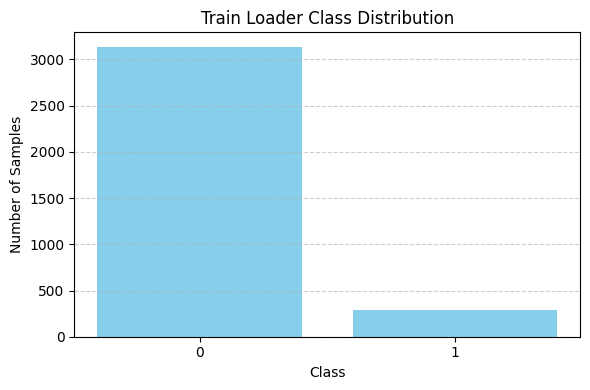

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Accumulate labels from train_loader
all_labels = []

for image, tabular, labels in train_loader:
    all_labels.extend(labels.tolist())

# Count class distribution
class_distribution = Counter(all_labels)

# Print class-wise counts
print("Class Distribution in Train Loader:")
for cls in sorted(class_distribution.keys()):
    print(f"  Class {cls}: {class_distribution[cls]} samples")

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xticks(list(class_distribution.keys()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Train Loader Class Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
model = MultiModalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_aucs, val_aucs = [], [], [], []
best_val_auc = 0.0  # Keep track of best AUC

for epoch in range(1, 6):
    # === TRAIN ===
    model.train()
    epoch_loss = 0
    all_probs, all_labels = [], []

    for images, metadata, labels in train_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_auc = roc_auc_score(all_labels, all_probs)
    train_losses.append(epoch_loss / len(train_loader))
    train_aucs.append(train_auc)

    print(f"Epoch {epoch} | Train Loss: {epoch_loss / len(train_loader):.4f} | Train AUC: {train_auc:.4f}")

    # === VALIDATION ===
    model.eval()
    val_loss = 0
    val_probs, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)

            val_probs.extend(probs.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_auc = roc_auc_score(val_labels, val_probs)
    val_losses.append(val_loss / len(val_loader))
    val_aucs.append(val_auc)

    print(f"Val Loss: {val_loss / len(val_loader):.4f} | Val AUC: {val_auc:.4f}")
    # print("Confusion Matrix (Val):")
    # print(confusion_matrix(val_labels, val_preds))
     # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")


Epoch 1 | Train Loss: 0.9220 | Train AUC: 0.7590
Val Loss: 1.0454 | Val AUC: 0.6092
Epoch 2 | Train Loss: 0.3473 | Train AUC: 0.8078
Val Loss: 1.2834 | Val AUC: 0.4879
Epoch 3 | Train Loss: 0.2968 | Train AUC: 0.8257
Val Loss: 1.1423 | Val AUC: 0.5754
Epoch 4 | Train Loss: 0.2613 | Train AUC: 0.8442
Val Loss: 1.1973 | Val AUC: 0.4875
Epoch 5 | Train Loss: 0.2610 | Train AUC: 0.8442
Val Loss: 1.3483 | Val AUC: 0.5678


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(images, tabular_data)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    # Calculate AUC
    auc = roc_auc_score(all_labels, all_probs)

    # Generate confusion matrix and classification report
    conf_mat = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)

    print(f"\n✅ Test AUC: {auc:.4f}")
    print(f"\nConfusion Matrix:\n{conf_mat}")
    print(f"\nClassification Report:\n{class_report}")


In [ ]:
# Paths
test_csv = "/content/drive/MyDrive/LUNA25/Test.csv"
test_image_dir = "/content/Preprocessed_test"

# Dataset & Loader
test_dataset = MultiModalNPYDataset(csv_file=test_csv, image_dir=test_image_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load trained model
model = MultiModalClassifier().to(device)
model.load_state_dict(torch.load('/content/best_model.pth'))  # Replace path

# Run test evaluation
evaluate_test(model, test_loader)



✅ Test AUC: 0.5056

Confusion Matrix:
[[   9 1676]
 [   1  199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.01      0.01      1685
           1       0.11      0.99      0.19       200

    accuracy                           0.11      1885
   macro avg       0.50      0.50      0.10      1885
weighted avg       0.82      0.11      0.03      1885



In [ ]:
## focal loss

In [ ]:
# Load full dataset
full_dataset = MultiModalNPYDataset(
    csv_file='/content/drive/MyDrive/LUNA25/Train.csv',
    image_dir='/content/Preprocessed_train'
)

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Balanced Sampling
labels_list = [sample[2].item() for sample in train_dataset]
class_counts = Counter(labels_list)
weights = [1.0 / class_counts[label] for label in labels_list]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Loss and optimizer
model = MultiModalClassifier().to(device)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(1, 5 + 1):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    y_true_train = []
    y_prob_train = []

    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images, tabular_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true_train.extend(labels.cpu().tolist())
        y_prob_train.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().tolist())

    train_auc = roc_auc_score(y_true_train, y_prob_train)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train AUC: {train_auc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true_val = []
    y_prob_val = []

    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)
            outputs = model(images, tabular_data)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            y_true_val.extend(labels.cpu().tolist())
            y_prob_val.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().tolist())

    val_auc = roc_auc_score(y_true_val, y_prob_val)
    val_acc = 100 * val_correct / val_total
    print(f"→ Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val AUC: {val_auc:.4f}")


Epoch 1 | Train Loss: 383.7138 | Train Acc: 77.17% | Train AUC: 0.5502
→ Val Loss: 2.2403 | Val Acc: 92.06% | Val AUC: 0.6378
Epoch 2 | Train Loss: 163.4483 | Train Acc: 85.09% | Train AUC: 0.5618
→ Val Loss: 0.7997 | Val Acc: 90.30% | Val AUC: 0.6430
Epoch 3 | Train Loss: 101.0918 | Train Acc: 83.60% | Train AUC: 0.5750
→ Val Loss: 0.8556 | Val Acc: 88.79% | Val AUC: 0.6777
Epoch 4 | Train Loss: 71.8585 | Train Acc: 83.43% | Train AUC: 0.5704
→ Val Loss: 0.9456 | Val Acc: 88.43% | Val AUC: 0.5864
Epoch 5 | Train Loss: 50.4472 | Train Acc: 84.39% | Train AUC: 0.5489
→ Val Loss: 0.8496 | Val Acc: 91.59% | Val AUC: 0.4509


In [ ]:
 torch.save(model.state_dict(), "best_model.pth")


In [ ]:
# Paths
test_csv = "/content/drive/MyDrive/LUNA25/Test.csv"
test_image_dir = "/content/Preprocessed_test"

# Dataset & Loader
test_dataset = MultiModalNPYDataset(csv_file=test_csv, image_dir=test_image_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load trained model
model = MultiModalClassifier().to(device)
model.load_state_dict(torch.load('/content/best_model.pth'))  # Replace path

# Run test evaluation
evaluate_test(model, test_loader)


✅ Test AUC: 0.4667

Confusion Matrix:
[[1685    0]
 [ 200    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1685
           1       0.00      0.00      0.00       200

    accuracy                           0.89      1885
   macro avg       0.45      0.50      0.47      1885
weighted avg       0.80      0.89      0.84      1885



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
### k fold

In [ ]:
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch
import numpy as np

# Define the MultiModalClassifier (assuming you already have this model class)
model = MultiModalClassifier()

# Prepare the full dataset
full_dataset = MultiModalNPYDataset(csv_file='/content/drive/MyDrive/LUNA25/Train.csv',
                                    image_dir='/content/Preprocessed_train')

# Split the dataset into training and validation sets
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Balanced Sampling
labels_list = [train_dataset[i][2].item() for i in range(len(train_dataset))]
class_counts = np.bincount(labels_list)
weights = [1.0 / class_counts[label] for label in labels_list]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = MultiModalClassifier().to(device)  # Ensure you move the model to GPU if necessary

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(1, 11):  # Example: 10 epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, tabular_data)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validate the model after each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Print validation statistics
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.2f}%\n")


Epoch 1, Loss: 1.2066, Accuracy: 54.82%
Validation Loss: 0.5451, Accuracy: 70.18%

Epoch 2, Loss: 0.8686, Accuracy: 60.72%
Validation Loss: 0.5074, Accuracy: 66.90%

Epoch 3, Loss: 0.7552, Accuracy: 66.48%
Validation Loss: 0.4760, Accuracy: 69.01%

Epoch 4, Loss: 0.6102, Accuracy: 69.70%
Validation Loss: 0.4466, Accuracy: 70.76%

Epoch 5, Loss: 0.5610, Accuracy: 73.50%
Validation Loss: 0.4681, Accuracy: 67.25%

Epoch 6, Loss: 0.5019, Accuracy: 76.42%
Validation Loss: 0.4036, Accuracy: 74.27%

Epoch 7, Loss: 0.4060, Accuracy: 81.88%
Validation Loss: 0.3579, Accuracy: 80.12%

Epoch 8, Loss: 0.3624, Accuracy: 83.52%
Validation Loss: 0.3437, Accuracy: 82.34%

Epoch 9, Loss: 0.2756, Accuracy: 88.40%
Validation Loss: 0.3911, Accuracy: 80.70%

Epoch 10, Loss: 0.2683, Accuracy: 89.68%
Validation Loss: 0.3092, Accuracy: 86.20%



In [ ]:
# Assuming you have a separate test dataset:
test_dataset = MultiModalNPYDataset(csv_file='/content/drive/MyDrive/LUNA25/Test.csv', image_dir='/content/Preprocessed_test')

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# After training with K-Fold cross-validation, evaluate the model on the test set
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # No need to track gradients during testing
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        # Forward pass: Get model predictions
        outputs = model(images, tabular_data)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions and calculate accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Final Test Set Evaluation
test_epoch_loss = test_loss / len(test_loader)
test_epoch_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.2f}%")


Test Loss: 2.2266, Test Accuracy: 83.61%


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model and test_loader
model.eval()  # Set the model to evaluation mode

y_true = []  # Ground truth labels
y_pred = []  # Model predictions
y_probs = []  # Probabilities for ROC-AUC

test_loss = 0.0
test_correct = 0
test_total = 0

# Iterate over test data
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        # Forward pass: Get model predictions
        outputs = model(images, tabular_data)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        prob = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class (class 1)

        # Accumulate statistics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(prob.cpu().numpy())

        # Calculate accuracy
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test metrics
test_epoch_loss = test_loss / len(test_loader)
test_epoch_acc = 100 * test_correct / test_total

# Print Test Loss and Accuracy
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.2f}%")


Test Loss: 2.2266, Test Accuracy: 83.61%


[[1518  167]
 [ 142   58]]


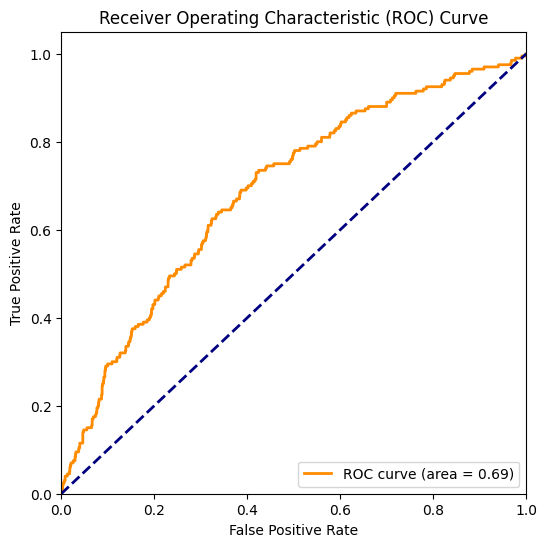

AUC Score: 0.6870


In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


# AUC (ROC Curve)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import numpy as np

# Example of Weighted Cross-Entropy Loss
class_weights = torch.tensor([1.0, 3.0]).to(device)  # Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop with Weighted Loss
for epoch in range(1, 10 + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_train = []  # Ground truth labels for training
    y_prob_train = []  # Probabilities for ROC-AUC in training

    # Training phase
    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, tabular_data)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate statistics for training
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store true labels and predicted probabilities for AUC calculation
        y_true_train.extend(labels.cpu().tolist())
        y_prob_train.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().tolist())  # Probabilities for class 1

    # Calculate training AUC
    train_auc = roc_auc_score(y_true_train, y_prob_train)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%, Training AUC: {train_auc:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true_val = []  # Ground truth labels for validation
    y_prob_val = []  # Probabilities for ROC-AUC in validation

    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, tabular_data)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Store true labels and predicted probabilities for AUC calculation
            y_true_val.extend(labels.cpu().tolist())
            y_prob_val.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().tolist())  # Probabilities for class 1

    # Calculate validation AUC
    val_auc = roc_auc_score(y_true_val, y_prob_val)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%, Validation AUC: {val_auc:.4f}")


Epoch 1, Training Loss: 0.0597, Training Accuracy: 97.95%, Training AUC: 0.9961
Epoch 1, Validation Loss: 0.8268, Validation Accuracy: 86.90%, Validation AUC: 0.8452
Epoch 2, Training Loss: 0.0311, Training Accuracy: 98.48%, Training AUC: 0.9988
Epoch 2, Validation Loss: 1.1390, Validation Accuracy: 91.35%, Validation AUC: 0.8443
Epoch 3, Training Loss: 0.0337, Training Accuracy: 98.89%, Training AUC: 0.9983
Epoch 3, Validation Loss: 1.0408, Validation Accuracy: 90.53%, Validation AUC: 0.8602
Epoch 4, Training Loss: 0.0286, Training Accuracy: 98.89%, Training AUC: 0.9990
Epoch 4, Validation Loss: 1.0911, Validation Accuracy: 90.53%, Validation AUC: 0.8556
Epoch 5, Training Loss: 0.0399, Training Accuracy: 98.48%, Training AUC: 0.9981
Epoch 5, Validation Loss: 1.1113, Validation Accuracy: 89.94%, Validation AUC: 0.8458
Epoch 6, Training Loss: 0.0212, Training Accuracy: 99.04%, Training AUC: 0.9993
Epoch 6, Validation Loss: 1.1019, Validation Accuracy: 92.16%, Validation AUC: 0.8588
Epoc